## **Breast Cancer Detection: MIAS Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('drive/My Drive/Major Project'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras


drive/My Drive/Major Project/cnn-mammography.ipynb
drive/My Drive/Major Project/breast-cancer mias.ipynb
drive/My Drive/Major Project/MIAS Breast_Cancer Detection.ipynb
drive/My Drive/Major Project/mias-mammography/Info.txt
drive/My Drive/Major Project/mias-mammography/all_mias_scans.h5
drive/My Drive/Major Project/mias-mammography/all-mias/mdb006.pgm
drive/My Drive/Major Project/mias-mammography/all-mias/mdb005.pgm
drive/My Drive/Major Project/mias-mammography/all-mias/mdb002.pgm
drive/My Drive/Major Project/mias-mammography/all-mias/Licence.txt
drive/My Drive/Major Project/mias-mammography/all-mias/mdb001.pgm
drive/My Drive/Major Project/mias-mammography/all-mias/mdb003.pgm
drive/My Drive/Major Project/mias-mammography/all-mias/mdb007.pgm
drive/My Drive/Major Project/mias-mammography/all-mias/mdb004.pgm
drive/My Drive/Major Project/mias-mammography/all-mias/Info.txt
drive/My Drive/Major Project/mias-mammography/all-mias/README
drive/My Drive/Major Project/mias-mammography/all-mias/md

In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")


All modules have been imported


# EDA (Exploratory Data Analysis)

In [ ]:
df = pd.read_csv('drive/My Drive/Major Project/mias-mammography/Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [ ]:
df['CLASS'] = [0 if x == 'NORM' else 1 for x in df['CLASS']]

In [ ]:
df.tail()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
325,mdb318,D,0,NaN,NaN,NaN,NaN
326,mdb319,D,0,NaN,NaN,NaN,NaN
327,mdb320,D,0,NaN,NaN,NaN,NaN
328,mdb321,D,0,NaN,NaN,NaN,NaN
329,mdb322,D,0,NaN,NaN,NaN,NaN


In [ ]:
labels = df.drop_duplicates(subset=['REFNUM'])['CLASS']

Finding unique values and description/ information of the dataset.

In [ ]:
df.describe()

,CLASS,X,Y,RADIUS
count,330.000000,119.000000,119.000000,119.000000
mean,0.372727,488.605042,520.983193,48.848739
std,0.484265,134.144131,178.828342,33.558863
min,0.000000,127.000000,125.000000,3.000000
25%,0.000000,398.500000,427.000000,27.000000
50%,0.000000,505.000000,524.000000,41.000000
75%,1.000000,574.500000,621.000000,61.500000
max,1.000000,793.000000,994.000000,197.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   REFNUM    330 non-null    object 
 1   BG        330 non-null    object 
 2   CLASS     330 non-null    int64  
 3   SEVERITY  123 non-null    object 
 4   X         119 non-null    float64
 5   Y         119 non-null    float64
 6   RADIUS    119 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 18.2+ KB


In [ ]:
df.nunique()

REFNUM      322
BG            3
CLASS         2
SEVERITY      2
X           105
Y           110
RADIUS       70
dtype: int64

Shape & Correlation of dataset.

In [ ]:
df.shape

(330, 7)

In [ ]:
df.corr()


,X,Y,RADIUS
X,1.000000,-0.118541,-0.030858
Y,-0.118541,1.000000,-0.027252
RADIUS,-0.030858,-0.027252,1.000000


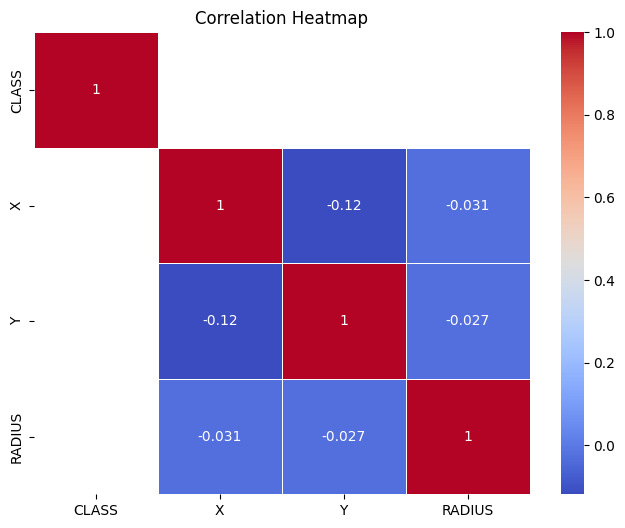

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix from your dataset, for example:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
info=pd.read_csv("/content/drive/MyDrive/Major Project/mias-mammography/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna(0)

0      B
1      B
2      0
3      0
4      B
      ..
325    0
326    0
327    0
328    0
329    0
Name: SEVERITY, Length: 330, dtype: object

# *Graphical Visualization*

 # CLASS vs SEVERITY (Benign, Malignant)

In [ ]:
Top_10_CLASS = df.groupby("SEVERITY").CLASS.sum().nlargest(n =10)



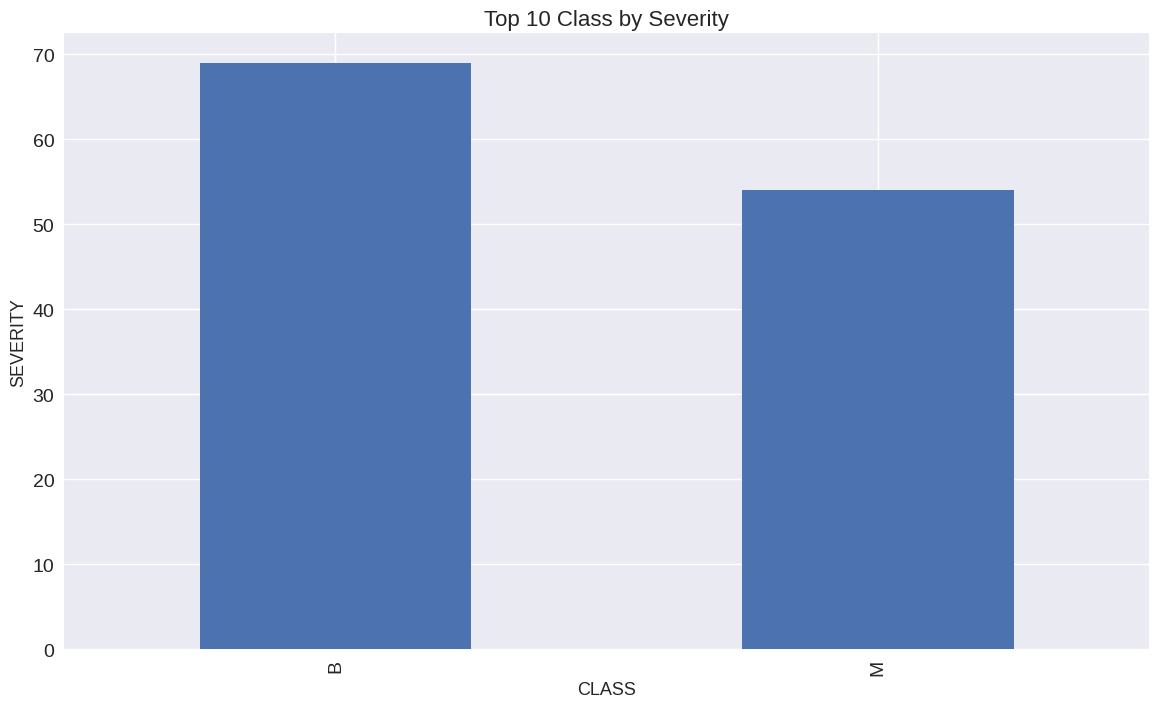

In [ ]:
plt.style.use('seaborn')
Top_10_CLASS.plot(kind ='bar', figsize =(14,8), fontsize =14)
plt.xlabel("CLASS", fontsize =13)
plt.ylabel("SEVERITY",fontsize =13)
plt.title("Top 10 Class by Severity",fontsize =16)
plt.show()

# Class vs BG (Type of tissue)

In [ ]:
Top_10_CLASS = df.groupby("BG").CLASS.sum().nlargest(n =10)

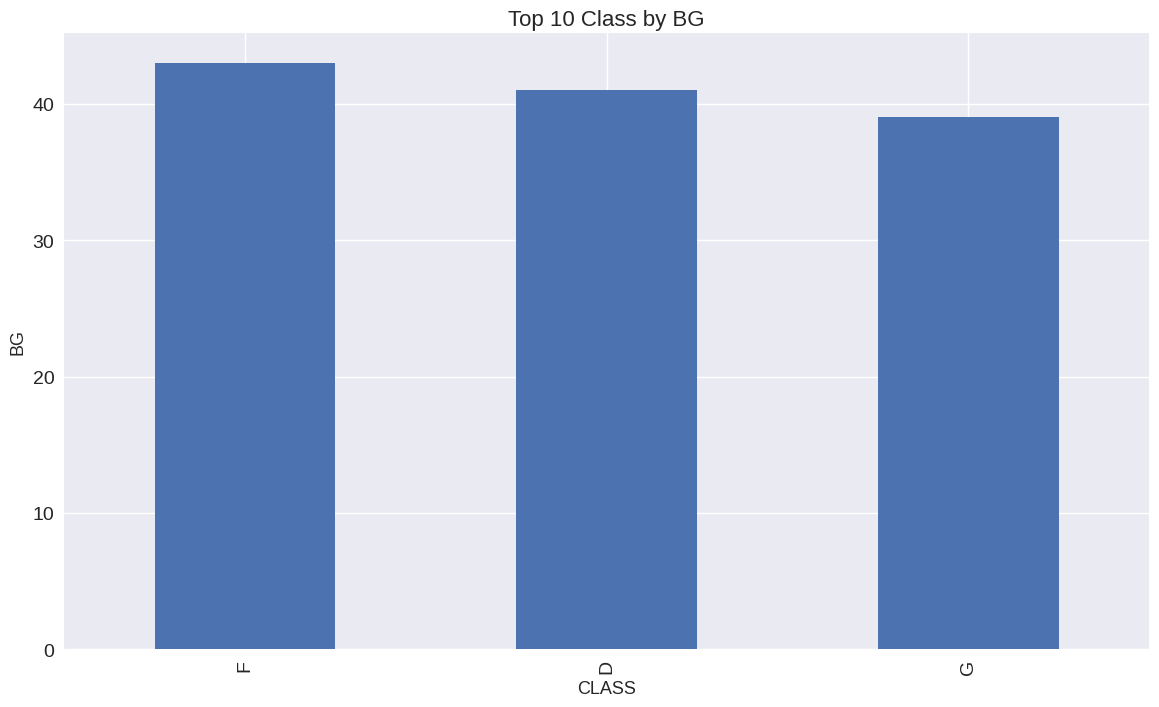

In [ ]:
plt.style.use('seaborn')
Top_10_CLASS.plot(kind ='bar', figsize =(14,8), fontsize =14)
plt.xlabel("CLASS", fontsize =13)
plt.ylabel("BG",fontsize =13)
plt.title("Top 10 Class by BG",fontsize =16)
plt.show()

# Showing Breast Cancer image.

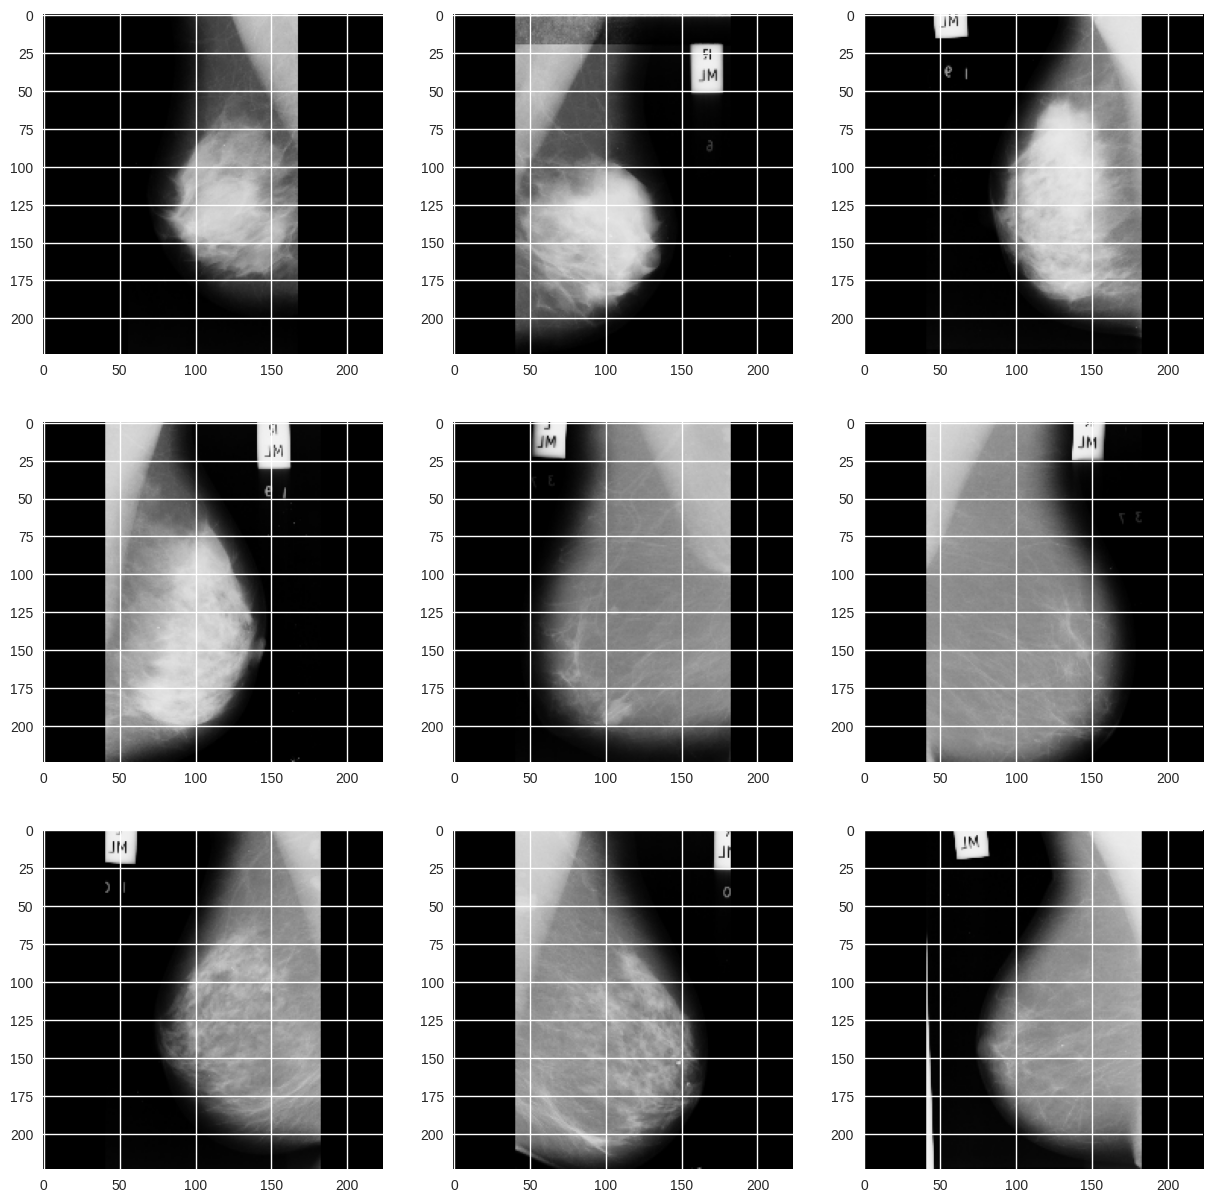

In [ ]:
from PIL import Image
import cv2
import glob
import matplotlib.pyplot as plt

x = []

for filename in sorted(glob.glob("/content/drive/MyDrive/Major Project/mias-mammography/all-mias/*.pgm")):
    img = cv2.imread(filename)
    img = cv2.resize(img, (224, 224))
    x.append(img)

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3

for i in range(1, columns * rows + 1):
    img = x[i - 1]  # Access the loaded image
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for display

plt.show()


In [ ]:
# Image Augmentation
no_angles = 360
url = '/content/drive/MyDrive/Major Project/mias-mammography/all-mias/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

Reading & Printing the image and label values.

In [ ]:
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)

In [ ]:
import os
import sys

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))

def read_lable():
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>1:
            if (words[1] == 'G'):
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 2
            if (words[1] == 'D'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 1
            if (words[1] == 'F'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 0

    return (info)

In [ ]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys()
#del lable_info['Truth-Data:']
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
#Y=to_categorical(Y,3)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading images
10143 3042 1305


# *CNN Model*

In [ ]:
cnn_model=Sequential()
cnn_model.add(Dense(8, input_dim=3, kernel_initializer = 'uniform', activation = 'relu'))

cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(16, kernel_initializer = 'HeUniform', activation = 'relu'))
cnn_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))
cnn_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu'))


cnn_model.add(BatchNormalization())
cnn_model.add(Dense(8, kernel_initializer = 'uniform', activation = 'relu'))

cnn_model.add(Dropout( 0.2))

cnn_model.add(Dense(3,activation='softmax'))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 32        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 16)                144       
                                                                 
 dense_8 (Dense)             (None, 32)                544       
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                      

Implementing some algorithms.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier  # Make sure you have the xgboost library installed

names = [
    "K Nearest Neighbour Classifier",
    'SVM',
    "Random Forest Classifier",
    "AdaBoost Classifier",
    "XGB Classifier",
]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
]

zipped_clf = zip(names, classifiers)


In [ ]:
def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)

    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)

    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)

    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),2)

    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("Training Accuracy : {}%".format(train_accuracy))

    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(val_accuracy))
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Recall score: {}".format(test_recall))
    print("Precision score : {}".format(test_precision))

    print("-"*80)
    print()

In [ ]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('Classifier', c)])
        print("------------------------------Fitting {} on input_data-------------------------------- ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [ ]:
base_model= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
val_features=model_feat.predict(x_val)
test_features=model_feat.predict(x_test)

41/41 [==============================] - 257s 6s/step


In [ ]:
from sklearn.pipeline import Pipeline
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)

------------------------------Fitting SVM on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Training Accuracy : 38.99%
------------------------ Validation Set Metrics------------------------

Accuracy score : 38.3%
------------------------ Test Set Metrics------------------------

Accuracy score : 39.31%
F1_score : 0.36
Recall score: 0.39
Precision score : 0.42
--------------------------------------------------------------------------------

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Training Accuracy : 100.0%
------------------------ Validation Set Metrics------------------------

Accuracy score : 35.83%
------------------------ Test Set Metrics------------------------

Accuracy score : 34.79%
F1_score : 0.35
Recall score: 0.35
Precision score : 0.35
------------------------------------

In [ ]:
train_y=to_categorical(y_train,3)
val_y=to_categorical(y_val,3)
test_y=to_categorical(y_test,3)
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(train_features, train_y,validation_data=(val_features,val_y), epochs=3)
loss_value , accuracy = cnn_model.evaluate(train_features, train_y)
print('Train_accuracy is:' + str(accuracy))
loss_value , accuracy = cnn_model.evaluate(val_features, val_y)
print('Validation_accuracy is := ' + str(accuracy))
loss_value , accuracy = cnn_model.evaluate(test_features, test_y)
print('test_accuracy is : = ' + str(accuracy))



Epoch 1/3
317/317 [==============================] - 6s 4ms/step - loss: 1.0968 - accuracy: 0.3518 - val_loss: 1.0961 - val_accuracy: 0.3711
Epoch 2/3
317/317 [==============================] - 1s 4ms/step - loss: 1.0920 - accuracy: 0.3603 - val_loss: 1.0910 - val_accuracy: 0.3731
Epoch 3/3
317/317 [==============================] - 1s 2ms/step - loss: 1.1133 - accuracy: 0.3343
Train_accuracy is:0.33431923389434814
96/96 [==============================] - 0s 2ms/step - loss: 1.1092 - accuracy: 0.3412
Validation_accuracy is := 0.341222882270813
41/41 [==============================] - 0s 2ms/step - loss: 1.1264 - accuracy: 0.3042
test_accuracy is : = 0.30421456694602966


In [ ]:
print("Performance Report:")
y_pred_prob1 = cnn_model.predict(test_features)  # Get predicted probabilities for each class
y_pred1 = np.argmax(y_pred_prob1, axis=1)  # Get the class with the highest probability as the prediction
y_test1 = [np.argmax(x) for x in test_y]  # Convert one-hot encoded true labels to class labels
target = ["G", "F", "D"]

from sklearn import metrics

print('Accuracy score is:', np.round(metrics.accuracy_score(y_test1, y_pred1), 4))
print('Precision score is:', np.round(metrics.precision_score(y_test1, y_pred1, average='weighted'), 4))
print('Recall score is:', np.round(metrics.recall_score(y_test1, y_pred1, average='weighted'), 4))
print('F1 Score is:', np.round(metrics.f1_score(y_test1, y_pred1, average='weighted'), 4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test1, y_pred1, target_names=target))


Performance Report:
41/41 [==============================] - 0s 3ms/step
Accuracy score is: 0.3042
Precision score is: 0.2675
Recall score is: 0.3042
F1 Score is: 0.1484
		Classification Report:
               precision    recall  f1-score   support

           G       0.30      1.00      0.46       392
           F       0.50      0.01      0.03       461
           D       0.00      0.00      0.00       452

    accuracy                           0.30      1305
   macro avg       0.27      0.34      0.16      1305
weighted avg       0.27      0.30      0.15      1305



# *PRE-DEFINED CNN MODEL*

# 1. InceptionV3

In [ ]:
base_Neural_Net= InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


87910968/87910968 [==============================] - 1s 0us/step


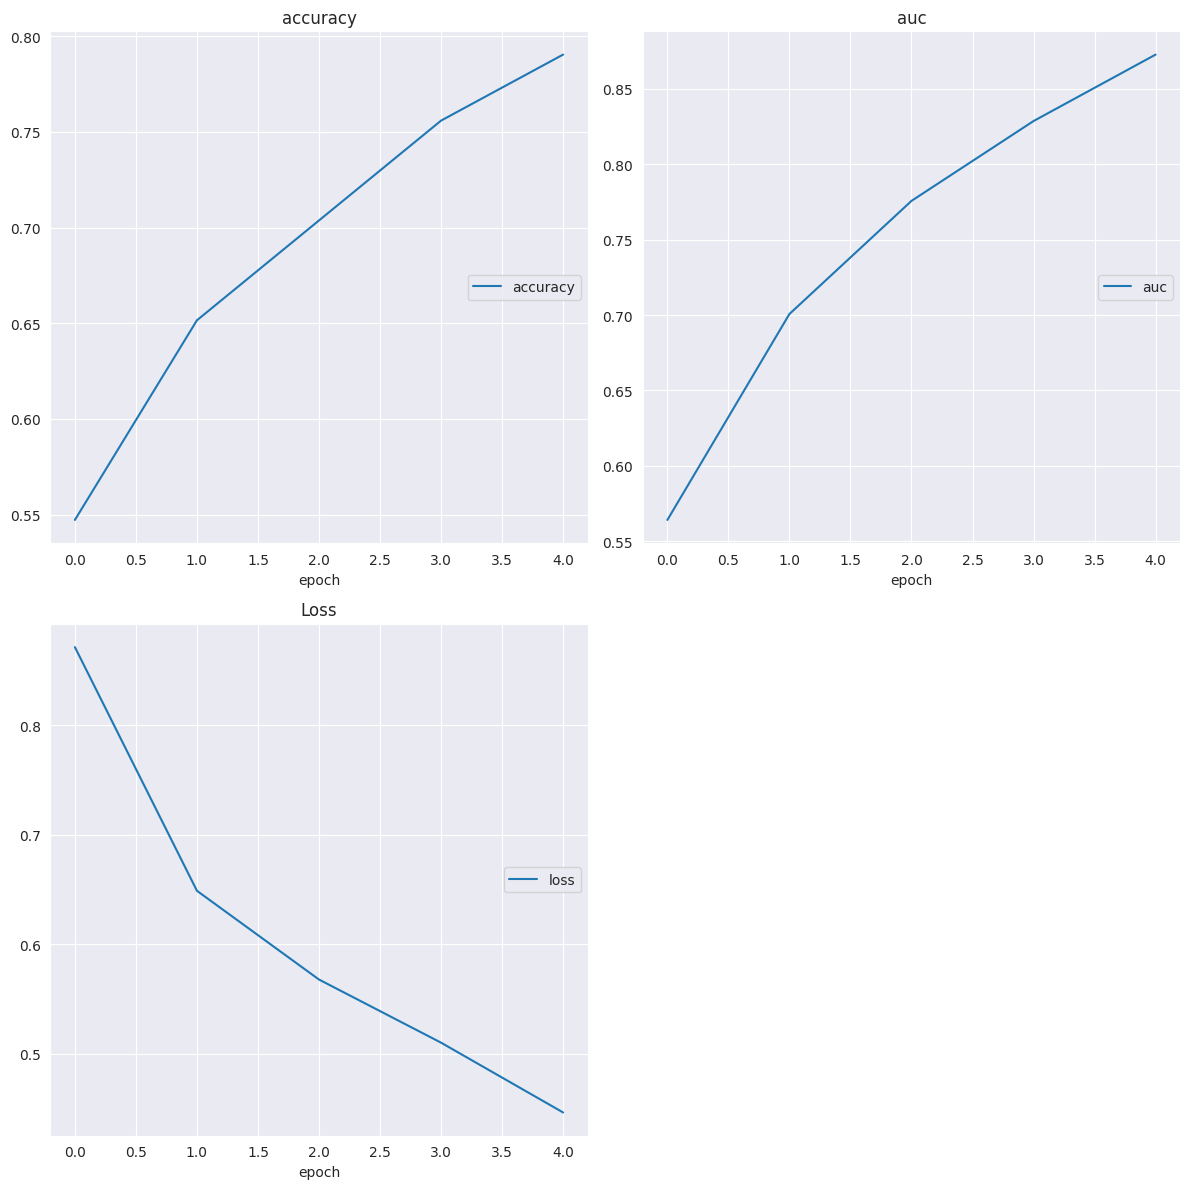

accuracy
	accuracy         	 (min:    0.547, max:    0.790, cur:    0.790)
auc
	auc              	 (min:    0.564, max:    0.873, cur:    0.873)
Loss
	loss             	 (min:    0.446, max:    0.871, cur:    0.446)
227/227 [==============================] - 429s 2s/step - loss: 0.4464 - accuracy: 0.7904 - auc: 0.8727 - lr: 0.0010


In [ ]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=5,callbacks=[c1,c3],batch_size=16)

In [ ]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

68/68 [==============================] - 117s 2s/step - loss: 0.5369 - accuracy: 0.7461 - auc: 0.8197


[0.5368744134902954, 0.7460901737213135, 0.8196952939033508]

In [ ]:
print("Shape of model predictions:", model.predict(x_test).shape)


15/15 [==============================] - 52s 3s/step
Shape of model predictions: (466, 2)


In [ ]:
print("Performance Report:")

# Predict classes using the model
predict_y = model.predict(x_test)
y_pred7 = np.argmax(predict_y, axis=1)

# Convert true labels to class labels
y_test7 = [np.argmax(x) for x in y_test]

# Define a function to calculate class probabilities
def predict_prob(y_pred):
    return np.max(y_pred, axis=1)

# Calculate class probabilities using the predict_prob function
y_pred_prb7 = predict_prob(model.predict(x_test))

target = ["B", "M"]
from sklearn import metrics

# Calculate and print various classification metrics
print('Accuracy score is:', np.round(metrics.accuracy_score(y_test7, y_pred7), 4))
print('Precision score is:', np.round(metrics.precision_score(y_test7, y_pred7, average='weighted'), 4))
print('Recall score is:', np.round(metrics.recall_score(y_test7, y_pred7, average='weighted'), 4))
print('F1 Score is:', np.round(metrics.f1_score(y_test7, y_pred7, average='weighted'), 4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test7, y_pred7, target_names=target))


Performance Report:
15/15 [==============================] - 251s 17s/step
Accuracy score is: 0.9378
Precision score is: 0.9378
Recall score is: 0.9378
F1 Score is: 0.9377
		Classification Report:
               precision    recall  f1-score   support

           B       0.94      0.95      0.95       265
           M       0.94      0.92      0.93       201

    accuracy                           0.94       466
   macro avg       0.94      0.94      0.94       466
weighted avg       0.94      0.94      0.94       466



# 2. VGG-16

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Activation, Dropout

base_Neural_Net = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 1s 0us/step


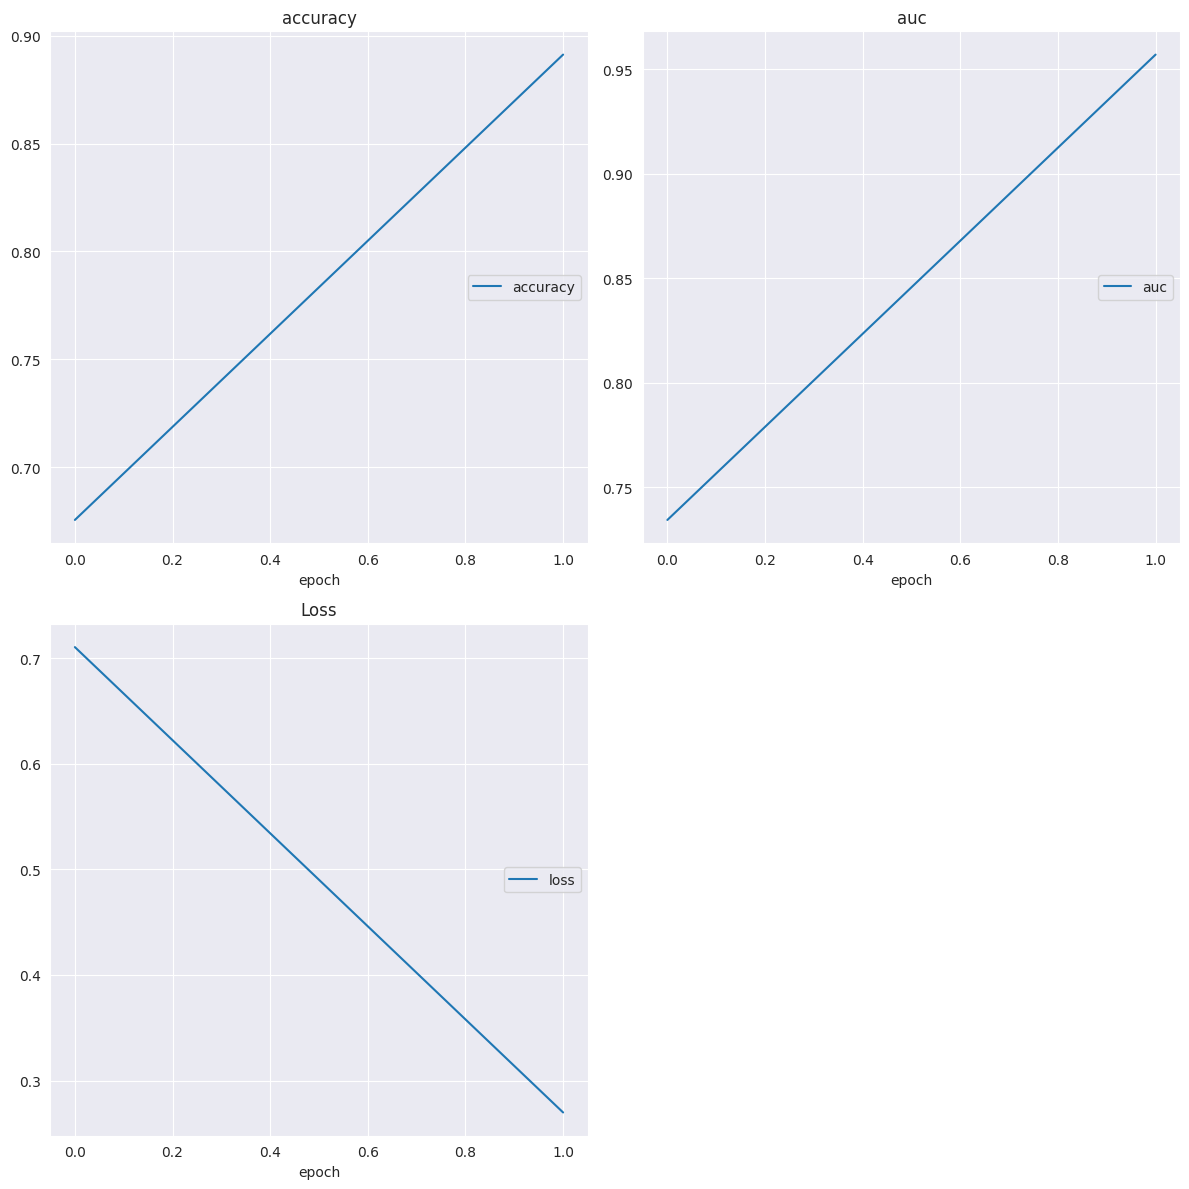

accuracy
	accuracy         	 (min:    0.676, max:    0.891, cur:    0.891)
auc
	auc              	 (min:    0.734, max:    0.957, cur:    0.957)
Loss
	loss             	 (min:    0.270, max:    0.710, cur:    0.270)
227/227 [==============================] - 1925s 8s/step - loss: 0.2698 - accuracy: 0.8912 - auc: 0.9571


In [ ]:
from livelossplot import PlotLossesKeras

# Define the callback
plot_losses = PlotLossesKeras()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
history = model.fit(x_train, y_train, epochs=2, callbacks=[plot_losses], batch_size=16)


In [ ]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

68/68 [==============================] - 593s 9s/step - loss: 0.1888 - accuracy: 0.9328 - auc: 0.9774


[0.1888454258441925, 0.9328426718711853, 0.9774051308631897]

In [ ]:
# ...
# Remove the line that defines y_pred_prb13
# ...
print("Performance Report:")
# Calculate performance metrics using predicted probabilities
from sklearn import metrics
y_pred_prob = model.predict(x_test)

# Calculate other metrics as before
print('Accuracy score is:', np.round(metrics.accuracy_score(y_test13, y_pred13), 4))
print('Precision score is:', np.round(metrics.precision_score(y_test13, y_pred13, average='weighted'), 4))
print('Recall score is:', np.round(metrics.recall_score(y_test13, y_pred13, average='weighted'), 4))
print('F1 Score is:', np.round(metrics.f1_score(y_test13, y_pred13, average='weighted'), 4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test13, y_pred13, target_names=target))


Performance Report:
15/15 [==============================] - 266s 18s/step
Accuracy score is: 0.9378
Precision score is: 0.9378
Recall score is: 0.9378
F1 Score is: 0.9377
		Classification Report:
               precision    recall  f1-score   support

           B       0.94      0.95      0.95       265
           M       0.94      0.92      0.93       201

    accuracy                           0.94       466
   macro avg       0.94      0.94      0.94       466
weighted avg       0.94      0.94      0.94       466



# 3. ResNet50

In [ ]:
base_Neural_Net=ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
for layer in base_Neural_Net.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


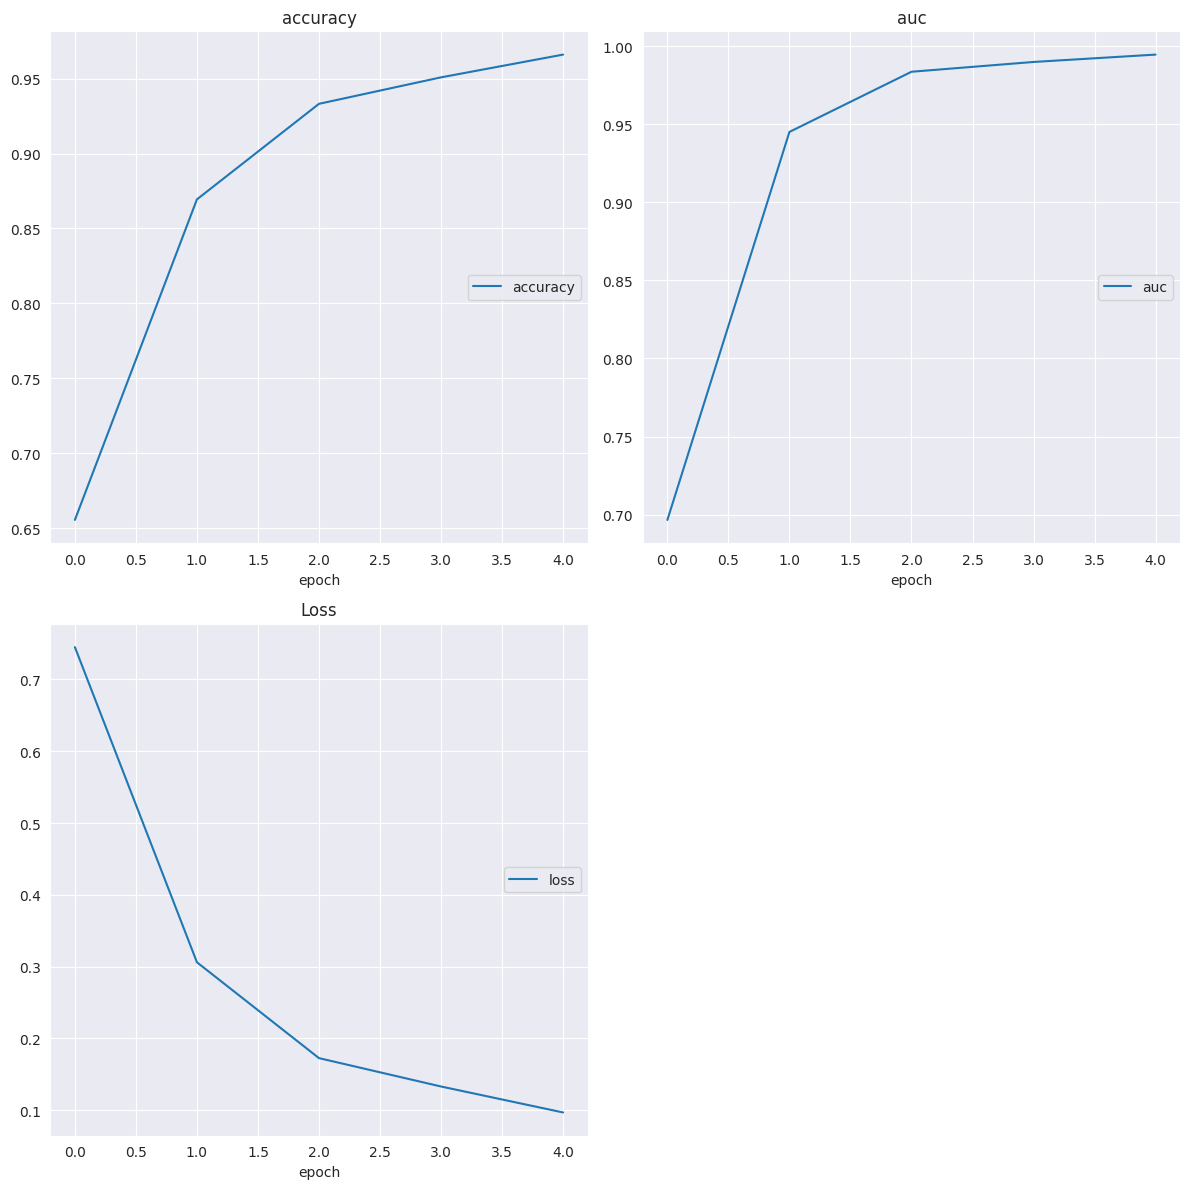

accuracy
	accuracy         	 (min:    0.655, max:    0.966, cur:    0.966)
auc
	auc              	 (min:    0.697, max:    0.995, cur:    0.995)
Loss
	loss             	 (min:    0.097, max:    0.745, cur:    0.097)
227/227 [==============================] - 703s 3s/step - loss: 0.0970 - accuracy: 0.9660 - auc: 0.9945 - lr: 0.0010


In [ ]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=5,callbacks=[c1,c3],batch_size=16)

In [ ]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

68/68 [==============================] - 210s 3s/step - loss: 0.2085 - accuracy: 0.9181 - auc: 0.9762


[0.20846210420131683, 0.9181233048439026, 0.9761951565742493]

In [ ]:
print("Performance Report:")

#y_pred6=model.predict_classes(x_test)
predict_y=model.predict(x_test)
y_pred5=np.argmax(predict_y,axis=1)

y_test5=[np.argmax(x) for x in y_test]

#y_pred_prb6=model.predict_proba(x_test)
def predict_prob(number):
  return [number[0],1-number[0]]
y_pred_prb5 = np.array(list(map(predict_prob, model.predict(x_test))))

target=["B","M"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test5, y_pred5),4))
print('Precision score is :', np.round(metrics.precision_score(y_test5, y_pred5, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test5,y_pred5, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test5, y_pred5, average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test5, y_pred5,target_names=target))


Performance Report:
15/15 [==============================] - 92s 6s/step
Accuracy score is : 0.9335
Precision score is : 0.9339
Recall score is : 0.9335
F1 Score is : 0.9336
		Classification Report:
               precision    recall  f1-score   support

           B       0.95      0.93      0.94       265
           M       0.91      0.94      0.92       201

    accuracy                           0.93       466
   macro avg       0.93      0.93      0.93       466
weighted avg       0.93      0.93      0.93       466

